# Imports

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as df
#from dask_ml.impute import SimpleImputer
#from dask_ml.xgboost import XGBClassifier
#from dask_ml.preprocessing import LabelEncoder
#from dask_ml.model_selection import KFold
#from dask_ml.linear_model import LogisticRegression
from dask.distributed import Client, LocalCluster
from dask import compute
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import ttest_ind, ttest_rel
from collections import namedtuple
from recordtype import recordtype

sns.set(style="darkgrid")
numpy.set_printoptions(suppress=True)
#numpy.seterr(divide='ignore', invalid='ignore')

In [22]:
SEED = 0
JOBS = 10

In [203]:
cluster = LocalCluster(n_workers=JOBS)
client = Client(cluster)

# Data Exploration

In [246]:
data = df.read_csv('./data/train_transaction.csv', header=0).set_index('TransactionID')

In [235]:
data.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [236]:
data.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 393 entries, isFraud to V339
dtypes: object(14), float64(376), int64(3)

In [7]:
data['isFraud'].value_counts().compute()

0    569877
1     20663
Name: isFraud, dtype: int64

From the table we can see that we are dealing with an imbalanced dataset.

## Missing Values

In [56]:
data.loc[:, 'TransactionAmt': 'M9'].isnull().sum().compute()

TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614
D10                76022
D11               279287
D12               525823


In [247]:
sample_pos = data[data['isFraud']==1]
sample_neg = data[data['isFraud']==0].sample(frac=0.05, random_state=SEED)

In [248]:
sample = df.concat([sample_pos, sample_neg]).compute()

<AxesSubplot:xlabel='dist2'>

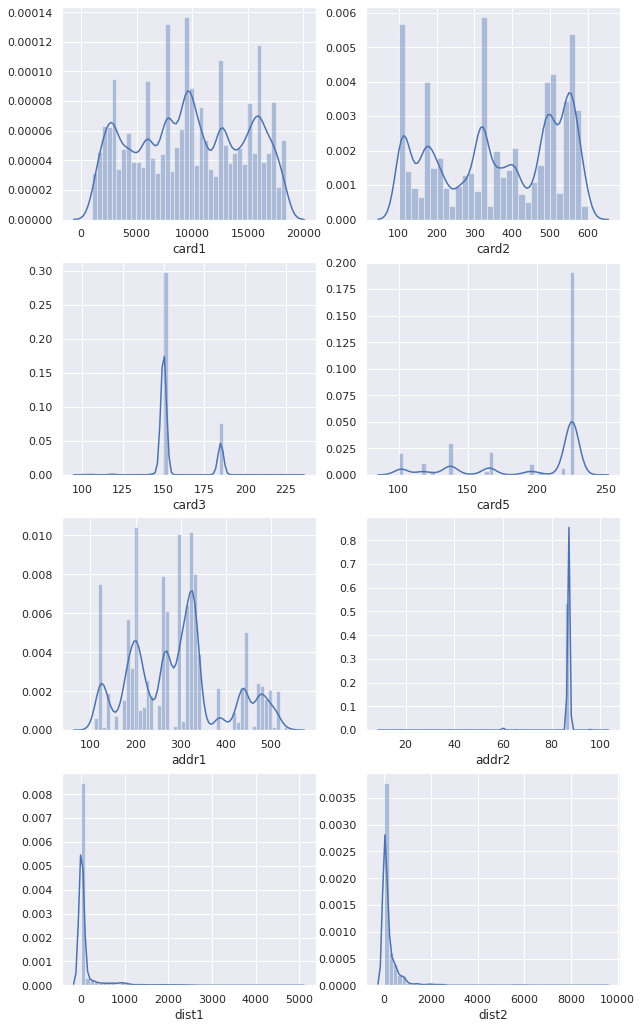

In [295]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,18))
sns.distplot(sample['card1'], ax=ax[0,0])
sns.distplot(sample['card2'], ax=ax[0,1])
sns.distplot(sample['card3'], ax=ax[1,0])
sns.distplot(sample['card5'], ax=ax[1,1])
sns.distplot(sample['addr1'], ax=ax[2,0])
sns.distplot(sample['addr2'], ax=ax[2,1])
sns.distplot(sample['dist1'], ax=ax[3,0])
sns.distplot(sample['dist2'], ax=ax[3,1])

In [251]:
sample.to_csv('./data/sample.csv', header=True, index=True)

In [3]:
types = {'TransactionAmt': 'float32',
         'ProductCD': 'category',
         'addr1': 'float32',
         'addr2': 'category',
         'dist1': 'float32',
         'dist2': 'float32',
         'P_emaildomain': 'category',
         'R_emaildomain': 'category',
         'card1': 'float32',
         'card2': 'float32',
         'card3': 'category',
         'card4': 'category',
         'card5': 'category',
         'card6': 'category'}

types.update({f'C{i}': 'float32' for i in range(1,15)})
types.update({f'M{i}': 'category' for i in range(1,10)})
types.update({f'D{i}': 'float32' for i in range(1,16)})
types.update({f'V{i}': 'float32' for i in range(1, 340)})

categorical = [k for k, v in types.items() if v == 'category']
numerical = [k for k, v in types.items() if v != 'category']

In [4]:
data = pandas.read_csv('./data/sample.csv', header=0, dtype=types).set_index('TransactionID')

In [5]:
data.drop(columns=['TransactionDT'], inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49156 entries, 2987203 to 3544102
Columns: 392 entries, isFraud to V339
dtypes: category(17), float32(374), int64(1)
memory usage: 71.7 MB


In [7]:
y = data['isFraud']
X = data.drop(columns=['isFraud'])
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,W,18268.0,583.0,150.0,visa,226.0,credit,251.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987240,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987243,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987245,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987288,155.520996,C,16578.0,545.0,185.0,visa,226.0,credit,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
y.value_counts()

0    28493
1    20663
Name: isFraud, dtype: int64

In [9]:
mean_imp = SimpleImputer(strategy='mean')
mode_imp = SimpleImputer(strategy='most_frequent')

In [10]:
X[numerical] = mean_imp.fit_transform(X[numerical])
X[categorical] = mode_imp.fit_transform(X[categorical])

In [326]:
X.isnull().sum()

TransactionAmt    0
ProductCD         0
card1             0
card2             0
card3             0
                 ..
V335              0
V336              0
V337              0
V338              0
V339              0
Length: 391, dtype: int64

## Visualization

In [328]:
X_ = X.copy()

In [329]:
X_[categorical] = X_[categorical].apply(LabelEncoder().fit_transform)

In [330]:
X_.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,4,18268.0,583.0,32,3,61,1,251.000000,30,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987240,37.098000,0,13413.0,103.0,48,3,21,1,291.550537,30,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987243,37.098000,0,13413.0,103.0,48,3,21,1,291.550537,30,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987245,37.098000,0,13413.0,103.0,48,3,21,1,291.550537,30,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987288,155.520996,0,16578.0,545.0,48,3,61,1,291.550537,30,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199


In [56]:
X_ = MinMaxScaler().fit_transform(X_)

In [57]:
X_ = TSNE(n_components=2, n_jobs=JOBS).fit_transform(X_)

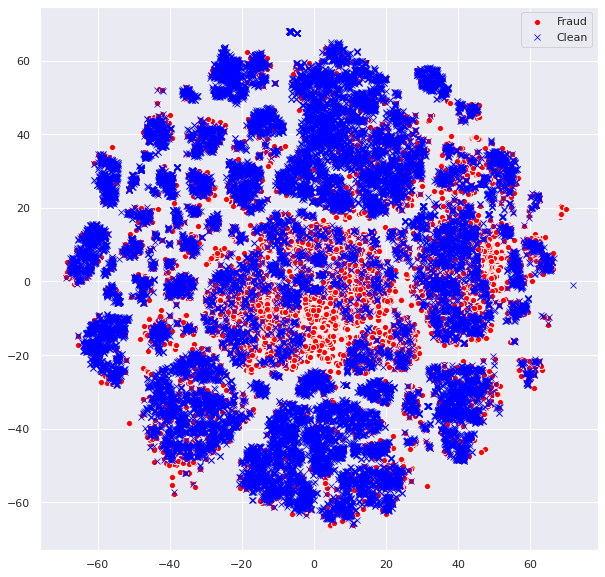

In [75]:
y_ = y.to_numpy()
plt.figure(figsize=(10,10))
sns.scatterplot(x=X_[y_==1, 0], y=X_[y_==1, 1], color='red', marker='o', label='Fraud')
sns.scatterplot(x=X_[y_==0, 0], y=X_[y_==0, 1], color='blue', marker='x', label='Clean')
plt.legend()

## Feature interaction

In [331]:
import hytests
from importlib import reload
reload(hytests)
from hytests import Hypot

In [333]:
X_ = X.copy()

In [334]:
X_[categorical] = X_[categorical].apply(LabelEncoder().fit_transform)

In [335]:
variance_filter = VarianceThreshold(threshold=0)
variance_filter.fit(X_)

VarianceThreshold(threshold=0)

In [336]:
constant_columns = [column for column in X_.columns if column not in X_.columns[variance_filter.get_support()]]
constant_columns

['M1', 'V1', 'V305']

In [337]:
tester = Hypot()

mapping = {k: 'cont' for k in numerical}
mapping.update({k: 'cat' for k in categorical})

del mapping['M1']
del mapping['V1']
del mapping['V305']


In [338]:
p = tester.test(data=X_, mapping=mapping)

In [339]:
p

,TransactionAmt,addr1,dist1,dist2,card1,card2,C1,C2,C3,C4,...,card5,card6,M2,M3,M4,M5,M6,M7,M8,M9
TransactionAmt,1.00000,0.00252,0.00007,0.82702,0.63840,0.00000,0.00000,0.00000,0.10459,0.00034,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000
addr1,0.00252,1.00000,0.29980,0.60249,0.00002,0.00000,0.85536,0.92152,0.45846,0.70254,...,0.00000,0.39179,0.01509,0.07750,0.00042,0.18651,0.00047,0.00000,0.00025,0.47596
dist1,0.00007,0.29980,1.00000,1.00000,0.00001,0.00707,0.59223,0.71771,1.00000,1.00000,...,0.99985,0.98421,0.00000,0.00000,0.01376,0.00000,0.00000,0.00000,0.00000,0.00000
dist2,0.82702,0.60249,1.00000,1.00000,0.27571,0.29661,0.55113,0.21939,0.12605,0.67664,...,0.02122,0.44757,1.00000,1.00000,0.64860,1.00000,1.00000,1.00000,1.00000,1.00000
card1,0.63840,0.00002,0.00001,0.27571,1.00000,0.68847,0.60785,0.87690,0.27036,0.47702,...,0.00000,0.00000,0.01638,0.00933,0.00000,0.00000,0.27825,0.76958,0.68056,0.00105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M5,0.00001,0.18651,0.00000,1.00000,0.00000,0.41166,0.00000,0.00000,0.00011,0.00000,...,0.00000,0.00000,0.00241,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00321
M6,0.00000,0.00047,0.00000,1.00000,0.27825,0.41435,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00107,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
M7,0.00000,0.00000,0.00000,1.00000,0.76958,0.00000,0.00031,0.00002,0.07083,0.00001,...,0.00000,0.02410,0.08581,0.10443,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
M8,0.00000,0.00025,0.00000,1.00000,0.68056,0.09521,0.00000,0.00000,0.00300,0.00000,...,0.00000,0.00000,0.04931,0.00004,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000


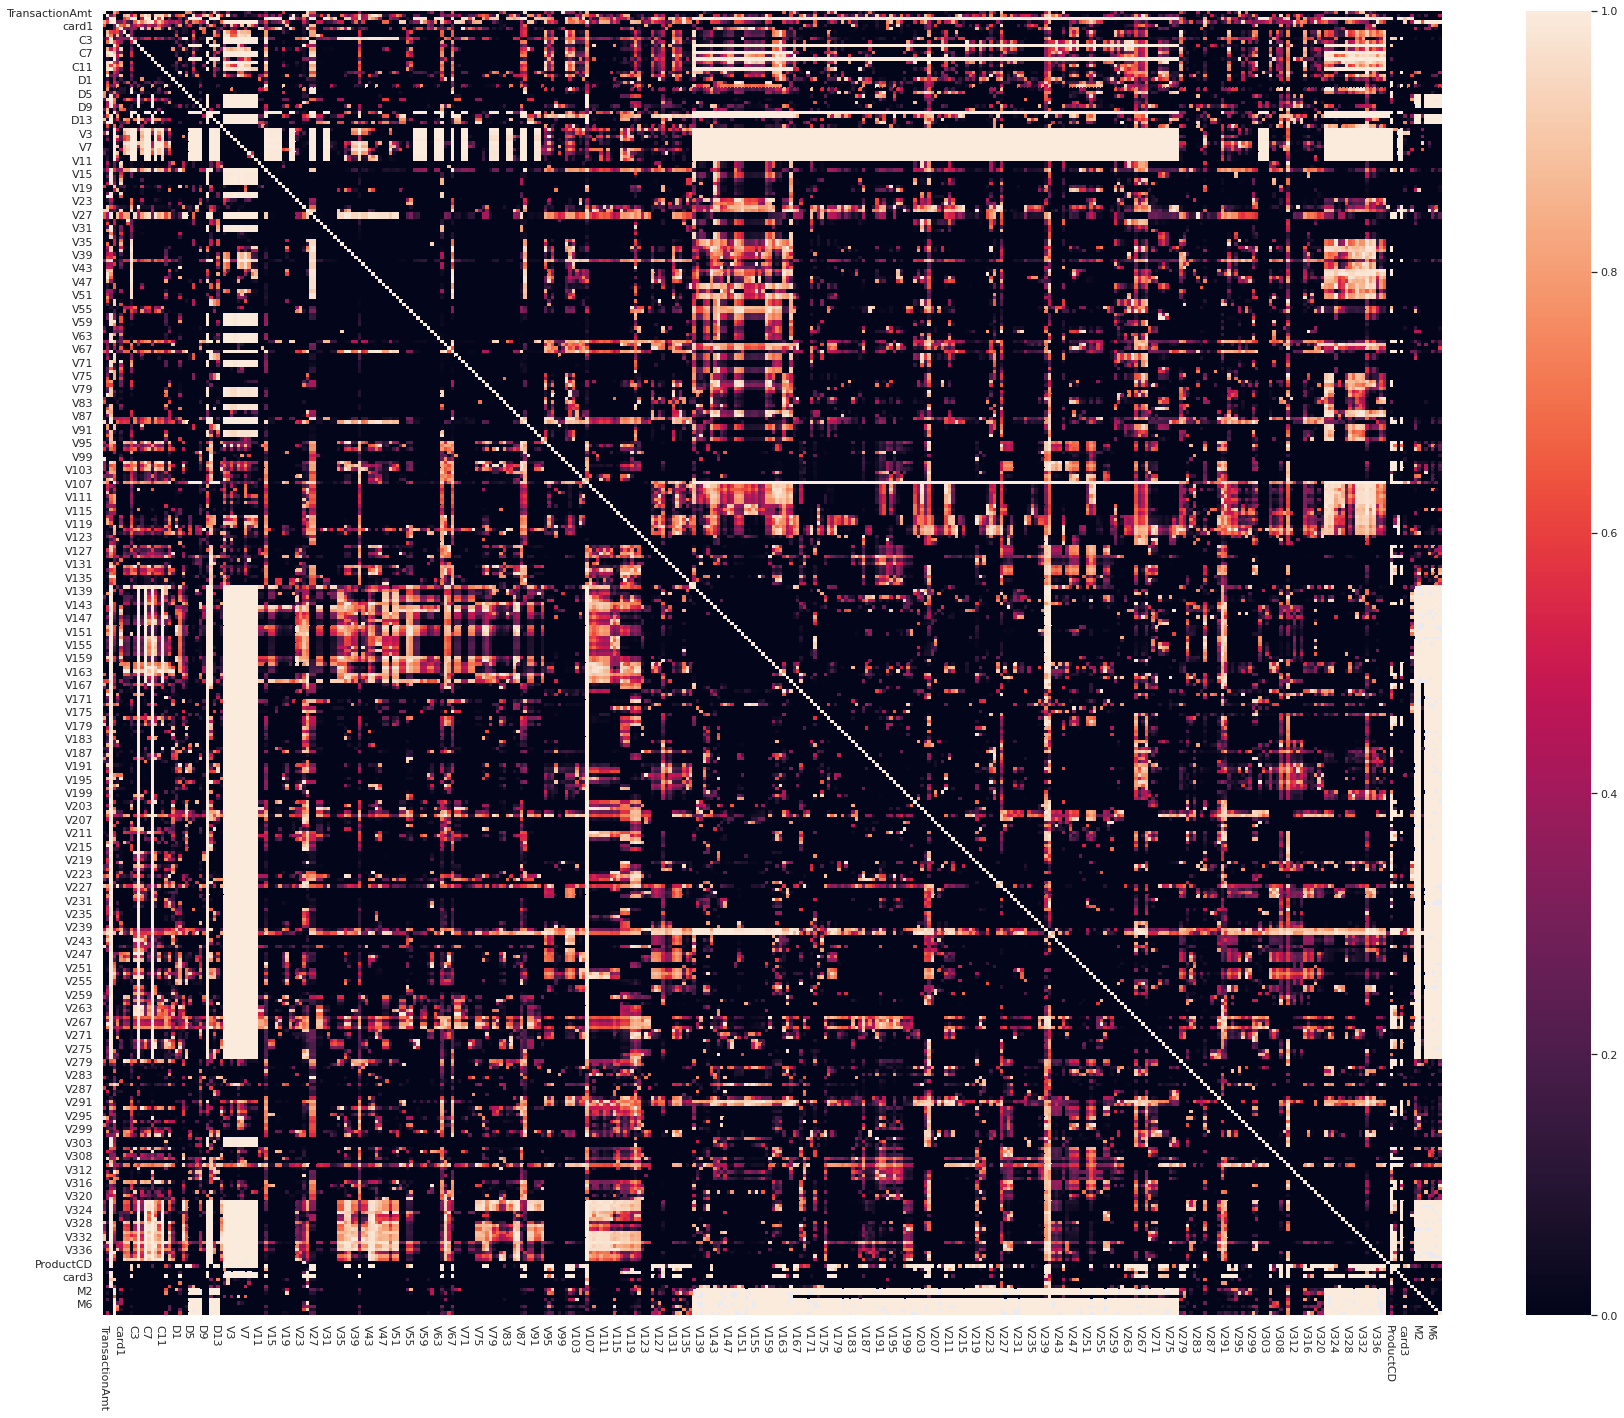

In [340]:
plt.figure(figsize=(30,24))
sns.heatmap(data=p, vmin=0, vmax=1)
plt.yticks(rotation=0)
plt.xticks(rotation=270)
plt.show()

# Modeling

## Base Dataset

In [11]:
X_base = X.copy()

In [12]:
X_base = X_base[['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'ProductCD', 'card4', 'card6']]

In [13]:
X_p = X_base[y==1]
X_n = X_base[y==0]

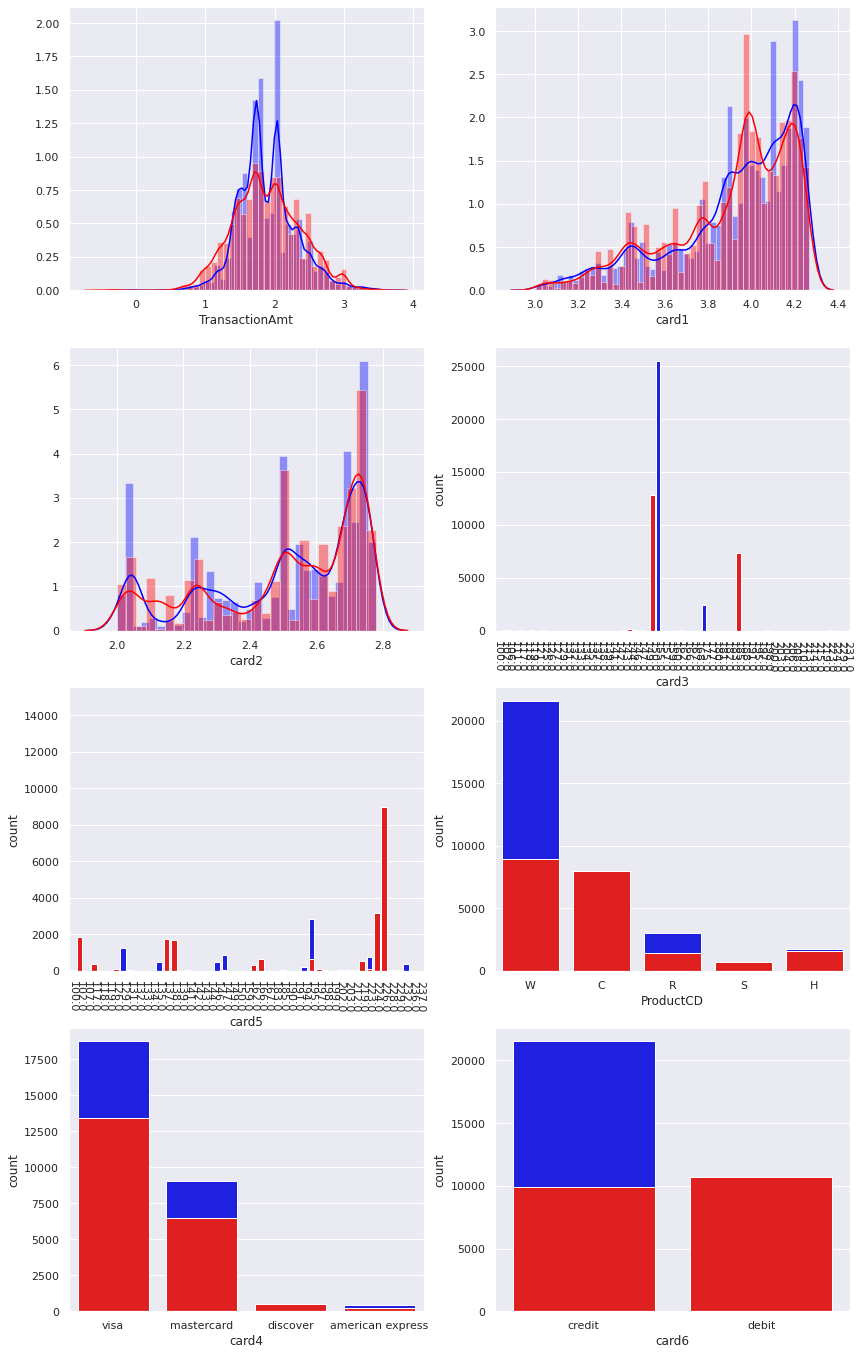

In [14]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(14,24))
sns.distplot(a=numpy.log10(X_n['TransactionAmt']), ax=ax[0,0], color='blue')
sns.distplot(a=numpy.log10(X_p['TransactionAmt']), ax=ax[0,0], color='red')
sns.distplot(a=numpy.log10(X_n['card1']), ax=ax[0,1], color='blue')
sns.distplot(a=numpy.log10(X_p['card1']), ax=ax[0,1], color='red')
sns.distplot(a=numpy.log10(X_n['card2']), ax=ax[1,0], color='blue')
sns.distplot(a=numpy.log10(X_p['card2']), ax=ax[1,0], color='red')
sns.countplot(x='card3', data=X_n, ax=ax[1,1], color='blue')
sns.countplot(x='card3', data=X_p, ax=ax[1,1], color='red')
sns.countplot(x='card5', data=X_n, ax=ax[2,0], color='blue')
sns.countplot(x='card5', data=X_p, ax=ax[2,0], color='red')
sns.countplot(x='ProductCD', data=X_n, ax=ax[2,1], color='blue')
sns.countplot(x='ProductCD', data=X_p, ax=ax[2,1], color='red')
sns.countplot(x='card4', data=X_n, ax=ax[3,0], color='blue')
sns.countplot(x='card4', data=X_p, ax=ax[3,0], color='red')
sns.countplot(x='card6', data=X_n, ax=ax[3,1], color='blue')
sns.countplot(x='card6', data=X_p, ax=ax[3,1], color='red')
ax[1,1].tick_params(axis='x', labelrotation=270)
ax[2,0].tick_params(axis='x', labelrotation=270)

## Baseline Model

In [15]:
X_ = pandas.get_dummies(X_base, columns=['card3', 'card4','card5','card6', 'ProductCD'], drop_first=True)

In [16]:
X_.head()

,TransactionAmt,card1,card2,card3_102.0,card3_106.0,card3_108.0,card3_111.0,card3_116.0,card3_117.0,card3_118.0,...,card5_235.0,card5_236.0,card5_237.0,card6_credit,card6_debit,card6_debit or credit,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2987240,37.098000,13413.0,103.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2987243,37.098000,13413.0,103.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2987245,37.098000,13413.0,103.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2987288,155.520996,16578.0,545.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [17]:
X_[['TransactionAmt','card1', 'card2']] = numpy.log10(X_[['TransactionAmt','card1', 'card2']]) 

In [18]:
X_.head()

,TransactionAmt,card1,card2,card3_102.0,card3_106.0,card3_108.0,card3_111.0,card3_116.0,card3_117.0,card3_118.0,...,card5_235.0,card5_236.0,card5_237.0,card6_credit,card6_debit,card6_debit or credit,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.648360,4.261691,2.765669,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2987240,1.569350,4.127526,2.012837,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2987243,1.569350,4.127526,2.012837,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2987245,1.569350,4.127526,2.012837,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2987288,2.191789,4.219532,2.736397,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [19]:
def ml_pipeline(X, y, n_splits, model, polynomial=False):
    
    X = X.to_numpy()
    y = y.to_numpy().reshape(-1, )
    
    if polynomial:
        pol = PolynomialFeatures(interaction_only=True)
        X = pol.fit_transform(X)
        
    Output = recordtype('Output', ['precision', 'recall', 'f1', 'aucPR', 'aucROC','aucs'])
    output = Output(precision=0, recall=0, f1=0, aucPR=0, aucROC=0, aucs=[])
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    for train_index, test_index in cv.split(X, y):
    
        X_train, X_test, y_train, y_test = X[train_index, :], X[test_index, :], y[train_index], y[test_index]

        model.fit(X=X_train, y=y_train)
        y_pred = model.predict(X_test)
        y_probs = model.predict_proba(X_test)[:, 1]
    
        recall = recall_score(y_true=y_test, y_pred=y_pred)
        precision = precision_score(y_true=y_test, y_pred=y_pred)
        f1 = f1_score(y_true=y_test, y_pred=y_pred)
        precisions, recalls, _ = precision_recall_curve(y_true=y_test, probas_pred=y_probs)
        fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_probs)
        aucROC = roc_auc_score(y_true=y_test, y_score=y_probs)
        aucPR = auc(recalls, precisions)
        
        output.recall += recall
        output.precision += precision
        output.f1 += f1
        output.aucPR += aucPR
        output.aucROC += aucROC
        output.aucs.append(aucPR)
        
        print(f'precision: {precision:0.4f}, recall: {recall:0.4f}, f1: {f1:0.4f}, aucPR: {aucPR:0.4f}, aucROC: {aucROC:0.4f}')
    
    output.recall /= n_splits
    output.precision /= n_splits
    output.f1 /= n_splits
    output.aucPR /= n_splits
    output.aucROC /= n_splits
    
    print(f'Final - precision: {output.precision:0.4f}, recall: {output.recall:0.4f}, f1: {output.f1:0.4f}, aucPR: {output.aucPR:0.4f}, aucROC: {output.aucROC:0.4f}')
    
    return output

In [20]:
model = LogisticRegression(random_state=SEED, n_jobs=JOBS)
lr_base = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.7019, recall: 0.5230, f1: 0.5994, aucPR: 0.6851, aucROC: 0.7488
precision: 0.6921, recall: 0.5438, f1: 0.6090, aucPR: 0.6833, aucROC: 0.7414
precision: 0.6933, recall: 0.5448, f1: 0.6101, aucPR: 0.6856, aucROC: 0.7493
precision: 0.6950, recall: 0.5503, f1: 0.6143, aucPR: 0.6880, aucROC: 0.7544
precision: 0.6803, recall: 0.5460, f1: 0.6058, aucPR: 0.6814, aucROC: 0.7480
precision: 0.6983, recall: 0.5344, f1: 0.6054, aucPR: 0.6924, aucROC: 0.7461
precision: 0.7018, recall: 0.5615, f1: 0.6238, aucPR: 0.6982, aucROC: 0.7578
precision: 0.6998, recall: 0.5450, f1: 0.6128, aucPR: 0.6974, aucROC: 0.7538
precision: 0.7038, recall: 0.5358, f1: 0.6084, aucPR: 0.7051, aucROC: 0.7496
precision: 0.6773, recall: 0.5242, f1: 0.5910, aucPR: 0.6779, aucROC: 0.7438
Final - precision: 0.6944, recall: 0.5409, f1: 0.6080, aucPR: 0.6894, aucROC: 0.7493


## XGBoost

In [23]:
X_ = X_base.copy()

In [24]:
X_[['TransactionAmt', 'card1', 'card2']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2']])
X_[['card4', 'card6', 'ProductCD', 'card3', 'card5']] = X_[['card4', 'card6', 'ProductCD', 'card3', 'card5']].apply(LabelEncoder().fit_transform)

In [25]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [26]:
scores = output.get_booster().get_score(importance_type="gain")

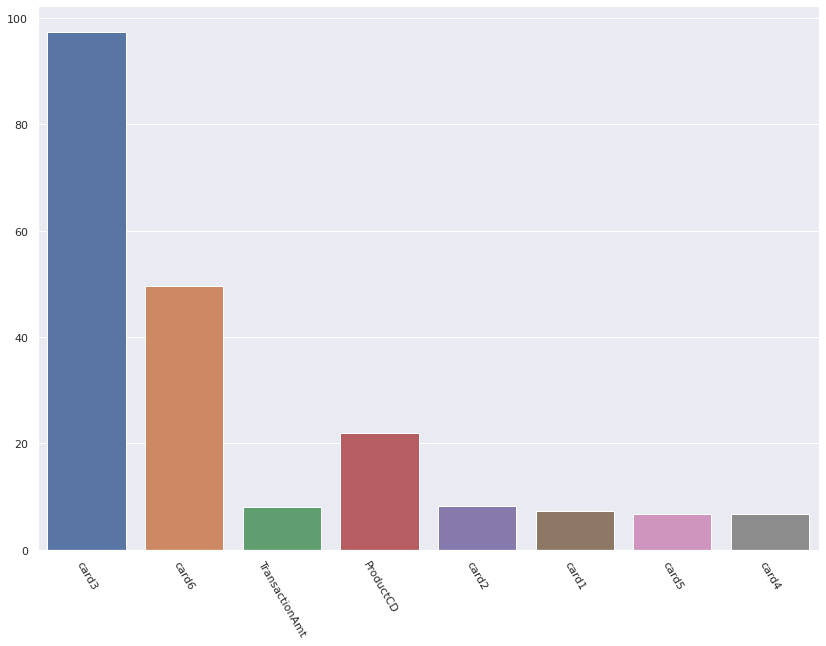

In [27]:
plt.figure(figsize=(14,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=300)
plt.show()

In [28]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_base = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.7735, recall: 0.6526, f1: 0.7080, aucPR: 0.7993, aucROC: 0.8495
precision: 0.7523, recall: 0.6744, f1: 0.7112, aucPR: 0.7898, aucROC: 0.8381
precision: 0.7765, recall: 0.6942, f1: 0.7331, aucPR: 0.8154, aucROC: 0.8599
precision: 0.7572, recall: 0.6791, f1: 0.7160, aucPR: 0.7960, aucROC: 0.8489
precision: 0.7549, recall: 0.6752, f1: 0.7128, aucPR: 0.7977, aucROC: 0.8456
precision: 0.7704, recall: 0.6675, f1: 0.7152, aucPR: 0.8019, aucROC: 0.8491
precision: 0.7474, recall: 0.6675, f1: 0.7052, aucPR: 0.7928, aucROC: 0.8420
precision: 0.7687, recall: 0.6854, f1: 0.7247, aucPR: 0.8109, aucROC: 0.8531
precision: 0.7600, recall: 0.6684, f1: 0.7113, aucPR: 0.8130, aucROC: 0.8527
precision: 0.7459, recall: 0.6592, f1: 0.6999, aucPR: 0.7886, aucROC: 0.8410
Final - precision: 0.7607, recall: 0.6724, f1: 0.7137, aucPR: 0.8005, aucROC: 0.8480


In [276]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_poly = ml_pipeline(X=X_, y=y, n_splits=10, model=model, polynomial=True)

precision: 0.7560, recall: 0.6730, f1: 0.7121, aucPR: 0.7999, aucROC: 0.8475
precision: 0.7539, recall: 0.6715, f1: 0.7103, aucPR: 0.7897, aucROC: 0.8428
precision: 0.7636, recall: 0.6812, f1: 0.7200, aucPR: 0.8113, aucROC: 0.8524
precision: 0.7474, recall: 0.6675, f1: 0.7052, aucPR: 0.7906, aucROC: 0.8437
precision: 0.7618, recall: 0.6810, f1: 0.7191, aucPR: 0.7934, aucROC: 0.8472
precision: 0.7531, recall: 0.6554, f1: 0.7008, aucPR: 0.7948, aucROC: 0.8411
precision: 0.7631, recall: 0.6859, f1: 0.7224, aucPR: 0.8046, aucROC: 0.8499
precision: 0.7563, recall: 0.6864, f1: 0.7196, aucPR: 0.7972, aucROC: 0.8457
precision: 0.7746, recall: 0.6820, f1: 0.7254, aucPR: 0.8176, aucROC: 0.8582
precision: 0.7742, recall: 0.6786, f1: 0.7232, aucPR: 0.8123, aucROC: 0.8600
Final - precision: 0.7604, recall: 0.6762, f1: 0.7158, aucPR: 0.8011, aucROC: 0.8489


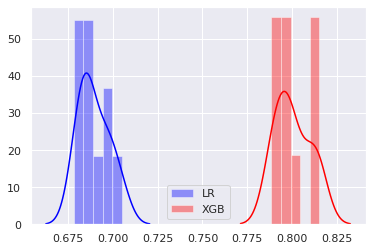

In [29]:
plt.figure()
sns.distplot(lr_base.aucs, color='blue', bins=5, label='LR')
sns.distplot(xgb_base.aucs, color='red', bins=5, label='XGB')
plt.legend()

In [30]:
ttest_rel(lr_base.aucs, xgb_base.aucs)

Ttest_relResult(statistic=-39.643349641827804, pvalue=2.0567998352683774e-11)

## Feature Expansion

### C features

In [31]:
C = X.loc[:, 'C1':'C14']

In [32]:
C_p = C[y==1]
C_n = C[y==0]

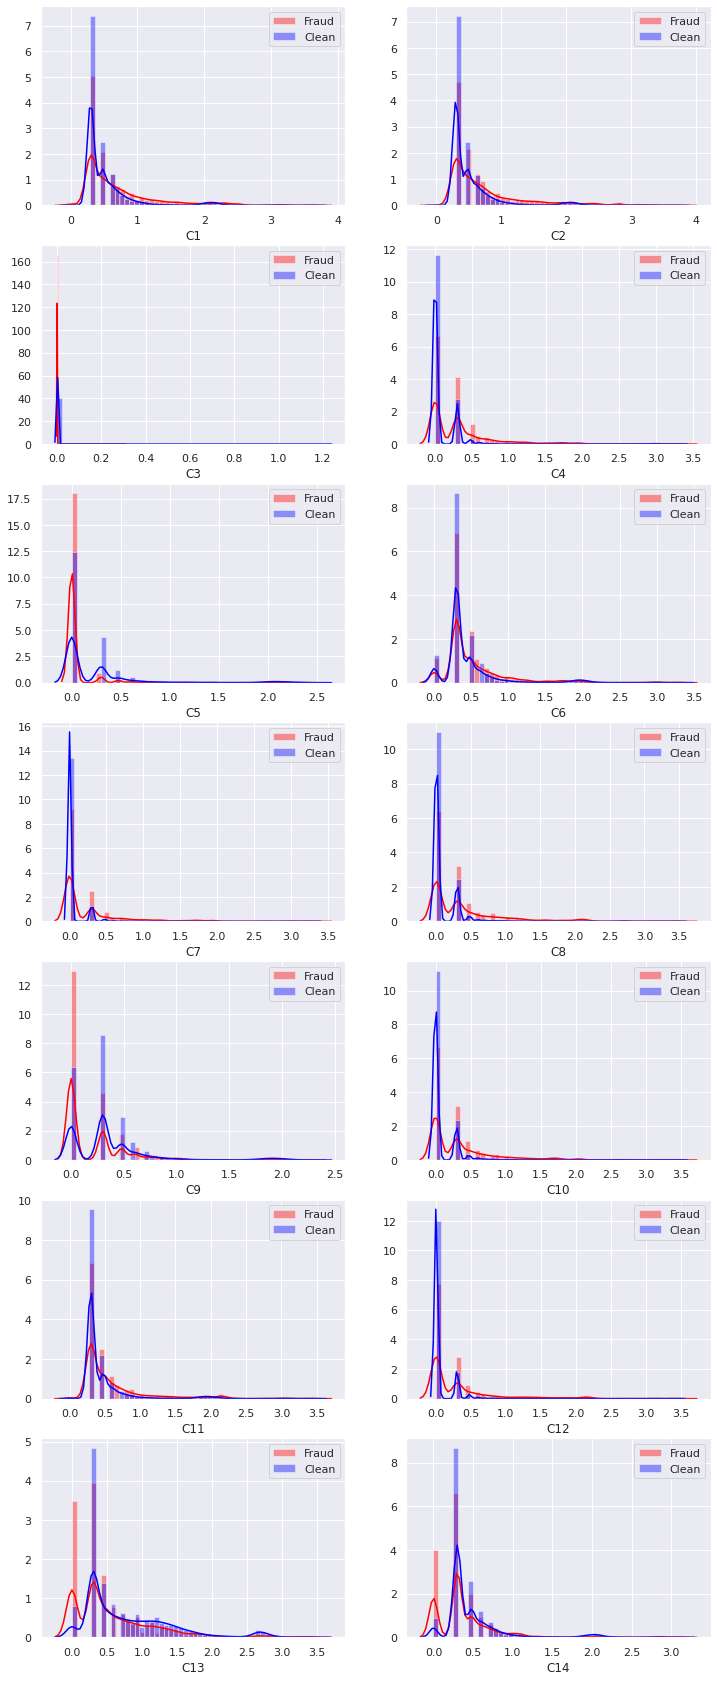

In [33]:

f, ax = plt.subplots(nrows=7, ncols=2, figsize=(12,30))

feature = 1
for row in range(0, 7):
    for col in range(0, 2):
        sns.distplot(numpy.log10(C_p[f'C{feature}'].add(1)), color='red', ax=ax[row,col], label='Fraud')
        sns.distplot(numpy.log10(C_n[f'C{feature}'].add(1)), color='blue', ax=ax[row,col], label='Clean')
        ax[row,col].legend()
        feature += 1
    

In [34]:
XC = X_base.join(C, how='inner')

In [35]:
XC.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0


In [36]:
X_ = XC.copy()

In [37]:
X_[['TransactionAmt', 'card1', 'card2']] = numpy.log10(XC[['TransactionAmt', 'card1', 'card2']])
X_.loc[:, 'C1':'C14'] = numpy.log10(XC.loc[:, 'C1':'C14'].add(1))
X_[['card3', 'card5', 'card4', 'card6', 'ProductCD']] = X_[['card3', 'card5', 'card4', 'card6', 'ProductCD']].apply(LabelEncoder().fit_transform)

In [38]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [39]:
scores = output.get_booster().get_score(importance_type="gain")

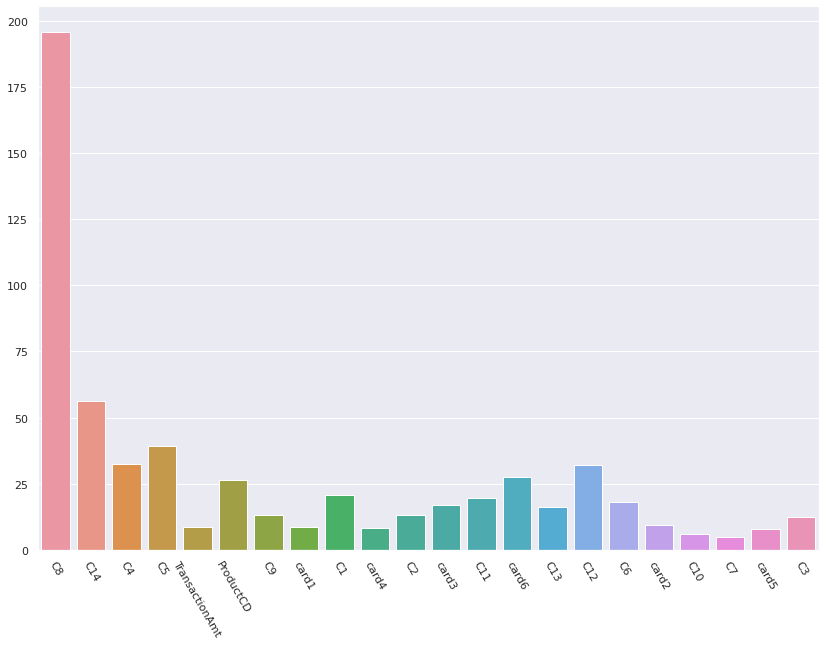

In [40]:
plt.figure(figsize=(14,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=300)
plt.show()

In [41]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.648360,4.261691,2.765669,32,61,4,3,1,0.477121,0.477121,...,0.0,0.477121,0.00000,0.00000,0.477121,0.00000,0.30103,0.00000,0.69897,0.477121
2987240,1.569350,4.127526,2.012837,48,21,0,3,1,0.000000,0.301030,...,0.0,0.301030,0.30103,0.30103,0.000000,0.30103,0.30103,0.30103,0.00000,0.000000
2987243,1.569350,4.127526,2.012837,48,21,0,3,1,0.301030,0.301030,...,0.0,0.301030,0.30103,0.30103,0.000000,0.30103,0.30103,0.30103,0.00000,0.000000
2987245,1.569350,4.127526,2.012837,48,21,0,3,1,0.477121,0.301030,...,0.0,0.301030,0.30103,0.30103,0.000000,0.30103,0.30103,0.30103,0.00000,0.000000
2987288,2.191789,4.219532,2.736397,48,61,0,3,1,0.301030,0.301030,...,0.0,0.301030,0.30103,0.30103,0.000000,0.30103,0.30103,0.30103,0.00000,0.000000


In [42]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_c = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8617, recall: 0.7625, f1: 0.8090, aucPR: 0.9116, aucROC: 0.9251
precision: 0.8531, recall: 0.7779, f1: 0.8138, aucPR: 0.9103, aucROC: 0.9220
precision: 0.8659, recall: 0.7905, f1: 0.8265, aucPR: 0.9213, aucROC: 0.9313
precision: 0.8683, recall: 0.7851, f1: 0.8246, aucPR: 0.9207, aucROC: 0.9331
precision: 0.8457, recall: 0.7749, f1: 0.8088, aucPR: 0.9077, aucROC: 0.9233
precision: 0.8607, recall: 0.7715, f1: 0.8137, aucPR: 0.9076, aucROC: 0.9202
precision: 0.8633, recall: 0.7609, f1: 0.8089, aucPR: 0.9133, aucROC: 0.9248
precision: 0.8731, recall: 0.7691, f1: 0.8178, aucPR: 0.9156, aucROC: 0.9277
precision: 0.8723, recall: 0.7638, f1: 0.8145, aucPR: 0.9126, aucROC: 0.9234
precision: 0.8567, recall: 0.7667, f1: 0.8092, aucPR: 0.9094, aucROC: 0.9218
Final - precision: 0.8621, recall: 0.7723, f1: 0.8147, aucPR: 0.9130, aucROC: 0.9252


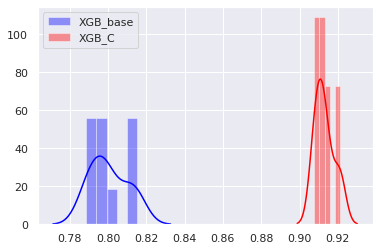

In [43]:
plt.figure()
sns.distplot(xgb_base.aucs, color='blue', bins=5, label='XGB_base')
sns.distplot(xgb_c.aucs, color='red', bins=5, label='XGB_C')
plt.legend()

In [44]:
ttest_rel(xgb_base.aucs, xgb_c.aucs)

Ttest_relResult(statistic=-41.196282929717704, pvalue=1.4579793055462137e-11)

In [45]:
C_sum = X_[[f'C{i}' for i in range(1,15)]].sum(axis=1)

In [46]:
X_['C_sum'] = C_sum
X_.drop(columns=[f'C{i}' for i in range(1,15)], inplace=True)

In [47]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C_sum
TransactionID,,,,,,,,,
2987203,2.648360,4.261691,2.765669,32,61,4,3,1,3.385606
2987240,1.569350,4.127526,2.012837,48,21,0,3,1,2.408240
2987243,1.569350,4.127526,2.012837,48,21,0,3,1,2.709270
2987245,1.569350,4.127526,2.012837,48,21,0,3,1,2.885361
2987288,2.191789,4.219532,2.736397,48,61,0,3,1,2.709270


In [48]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output_xgb = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8148, recall: 0.6855, f1: 0.7446, aucPR: 0.8539, aucROC: 0.8845
precision: 0.7960, recall: 0.6986, f1: 0.7441, aucPR: 0.8395, aucROC: 0.8702
precision: 0.8089, recall: 0.7107, f1: 0.7566, aucPR: 0.8586, aucROC: 0.8848
precision: 0.8152, recall: 0.7154, f1: 0.7621, aucPR: 0.8634, aucROC: 0.8904
precision: 0.8054, recall: 0.7014, f1: 0.7498, aucPR: 0.8480, aucROC: 0.8774
precision: 0.8084, recall: 0.6883, f1: 0.7435, aucPR: 0.8454, aucROC: 0.8717
precision: 0.8034, recall: 0.6922, f1: 0.7436, aucPR: 0.8481, aucROC: 0.8765
precision: 0.8159, recall: 0.7057, f1: 0.7568, aucPR: 0.8555, aucROC: 0.8822
precision: 0.8183, recall: 0.6955, f1: 0.7520, aucPR: 0.8528, aucROC: 0.8833
precision: 0.7871, recall: 0.6801, f1: 0.7297, aucPR: 0.8408, aucROC: 0.8691
Final - precision: 0.8074, recall: 0.6973, f1: 0.7483, aucPR: 0.8506, aucROC: 0.8790


### Adress features

In [49]:
G = X[['addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain']]

In [50]:
G.head()

,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
TransactionID,,,,,,
2987203,251.000000,87.0,134.04924,216.759171,aol.com,gmail.com
2987240,291.550537,87.0,134.04924,216.759171,hotmail.com,hotmail.com
2987243,291.550537,87.0,134.04924,216.759171,hotmail.com,hotmail.com
2987245,291.550537,87.0,134.04924,216.759171,hotmail.com,hotmail.com
2987288,291.550537,87.0,134.04924,216.759171,outlook.com,outlook.com


In [51]:
G_p = G[y==1]
G_n = G[y==0]

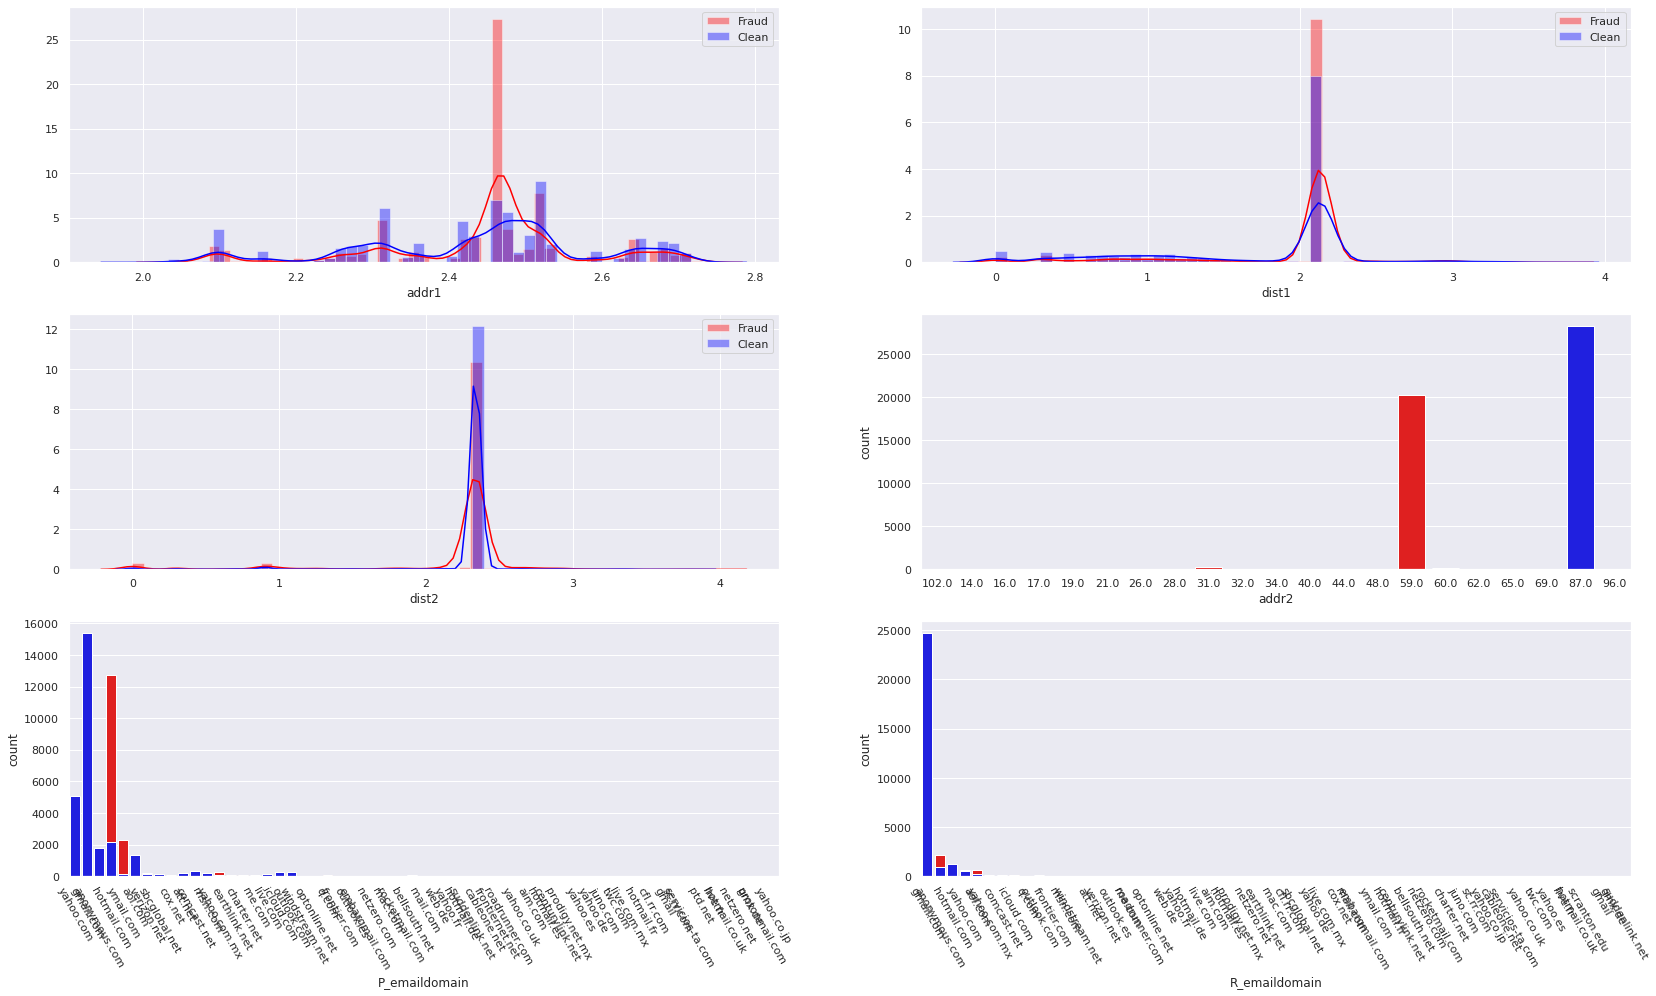

In [55]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(28,16))

features = ['addr1', 'dist1', 'dist2']
idx = 0
for row in range(0, 2):
    for col in range(0, 2):
        if idx < 3:
            sns.distplot(numpy.log10(G_p[features[idx]].add(1)), color='red', ax=ax[row,col], label='Fraud')
            sns.distplot(numpy.log10(G_n[features[idx]].add(1)), color='blue', ax=ax[row,col], label='Clean')
            ax[row,col].legend()
            idx += 1
            
sns.countplot(G_p['addr2'], color='red', ax=ax[1, 1], label='Fraud')
sns.countplot(G_n['addr2'], color='blue', ax=ax[1, 1], label='Clean')
sns.countplot(G_p['P_emaildomain'], color='red', ax=ax[2, 0], label='Fraud')
sns.countplot(G_n['P_emaildomain'], color='blue', ax=ax[2, 0], label='Clean')
sns.countplot(G_p['R_emaildomain'], color='red', ax=ax[2, 1], label='Fraud')
sns.countplot(G_n['R_emaildomain'], color='blue', ax=ax[2, 1], label='Clean')
ax[2,1].tick_params(axis='x', labelrotation=300)
ax[2,0].tick_params(axis='x', labelrotation=300)
plt.show()

In [56]:
XCG = XC.join(G, how='inner')

In [57]:
XCG.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,C11,C12,C13,C14,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,1.0,0.0,4.0,2.0,251.000000,87.0,134.04924,216.759171,aol.com,gmail.com
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,1.0,1.0,0.0,0.0,291.550537,87.0,134.04924,216.759171,hotmail.com,hotmail.com
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,1.0,1.0,0.0,0.0,291.550537,87.0,134.04924,216.759171,hotmail.com,hotmail.com
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,1.0,1.0,0.0,0.0,291.550537,87.0,134.04924,216.759171,hotmail.com,hotmail.com
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,1.0,1.0,0.0,0.0,291.550537,87.0,134.04924,216.759171,outlook.com,outlook.com


In [63]:
X_ = XCG.copy()

In [64]:
X_[['TransactionAmt', 'card1', 'card2', 'dist1', 'dist2', 'addr1']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2', 'dist1', 'dist2', 'addr1']].add(1))
X_.loc[:, 'C1':'C14'] = numpy.log10(X_.loc[:, 'C1':'C14'].add(1))
X_[['card3', 'card5', 'card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'addr2']] =\
X_[['card3', 'card5', 'card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'addr2']].apply(LabelEncoder().fit_transform)

In [65]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,C11,C12,C13,C14,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4.261715,2.766413,32,61,4,3,1,0.477121,0.477121,...,0.30103,0.00000,0.69897,0.477121,2.401401,30,2.130492,2.337976,2,15
2987240,1.580902,4.127558,2.017033,48,21,0,3,1,0.000000,0.301030,...,0.30103,0.30103,0.00000,0.000000,2.466201,30,2.130492,2.337976,19,18
2987243,1.580902,4.127558,2.017033,48,21,0,3,1,0.301030,0.301030,...,0.30103,0.30103,0.00000,0.000000,2.466201,30,2.130492,2.337976,19,18
2987245,1.580902,4.127558,2.017033,48,21,0,3,1,0.477121,0.301030,...,0.30103,0.30103,0.00000,0.000000,2.466201,30,2.130492,2.337976,19,18
2987288,2.194573,4.219558,2.737193,48,61,0,3,1,0.301030,0.301030,...,0.30103,0.30103,0.00000,0.000000,2.466201,30,2.130492,2.337976,35,34


In [66]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [68]:
scores = output.get_booster().get_score(importance_type="gain")

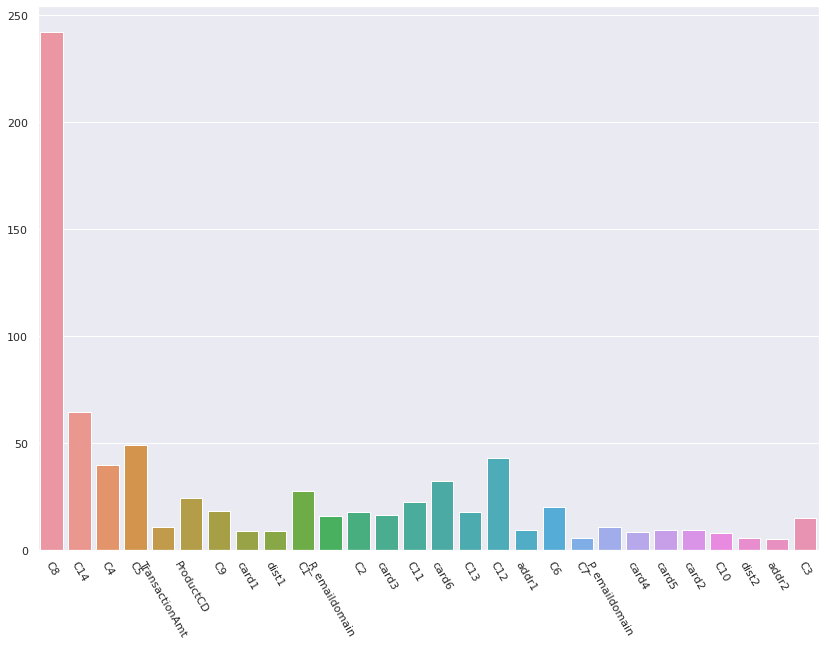

In [69]:
plt.figure(figsize=(14,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=300)
plt.show()

In [70]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_cg = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8802, recall: 0.7818, f1: 0.8281, aucPR: 0.9225, aucROC: 0.9329
precision: 0.8701, recall: 0.7876, f1: 0.8268, aucPR: 0.9155, aucROC: 0.9258
precision: 0.8755, recall: 0.7929, f1: 0.8322, aucPR: 0.9265, aucROC: 0.9378
precision: 0.8785, recall: 0.7977, f1: 0.8361, aucPR: 0.9288, aucROC: 0.9407
precision: 0.8570, recall: 0.7890, f1: 0.8216, aucPR: 0.9144, aucROC: 0.9284
precision: 0.8698, recall: 0.7793, f1: 0.8221, aucPR: 0.9170, aucROC: 0.9270
precision: 0.8727, recall: 0.7832, f1: 0.8255, aucPR: 0.9220, aucROC: 0.9319
precision: 0.8833, recall: 0.7803, f1: 0.8286, aucPR: 0.9241, aucROC: 0.9343
precision: 0.8867, recall: 0.7919, f1: 0.8366, aucPR: 0.9256, aucROC: 0.9356
precision: 0.8732, recall: 0.7803, f1: 0.8241, aucPR: 0.9187, aucROC: 0.9302
Final - precision: 0.8747, recall: 0.7864, f1: 0.8282, aucPR: 0.9215, aucROC: 0.9325


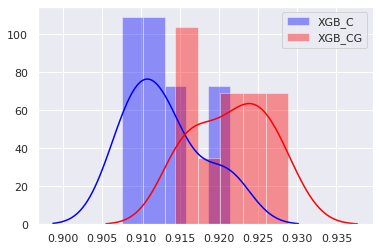

In [71]:
plt.figure()
sns.distplot(xgb_c.aucs, color='blue', bins=5, label='XGB_C')
sns.distplot(xgb_cg.aucs, color='red', bins=5, label='XGB_CG')
plt.legend()

In [72]:
ttest_rel(xgb_cg.aucs, xgb_c.aucs)

Ttest_relResult(statistic=11.023285577114054, pvalue=1.5814738024970881e-06)

### M features

In [73]:
features = [f'M{i}' for i in range(1,10)]

In [74]:
M = X.loc[:, features]

In [75]:
M.head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,
2987203,T,T,T,M0,F,T,F,F,T
2987240,T,T,T,M2,F,F,F,F,T
2987243,T,T,T,M2,F,F,F,F,T
2987245,T,T,T,M2,F,F,F,F,T
2987288,T,T,T,M2,F,F,F,F,T


In [76]:
M_p = M[y==1]
M_n = M[y==0]

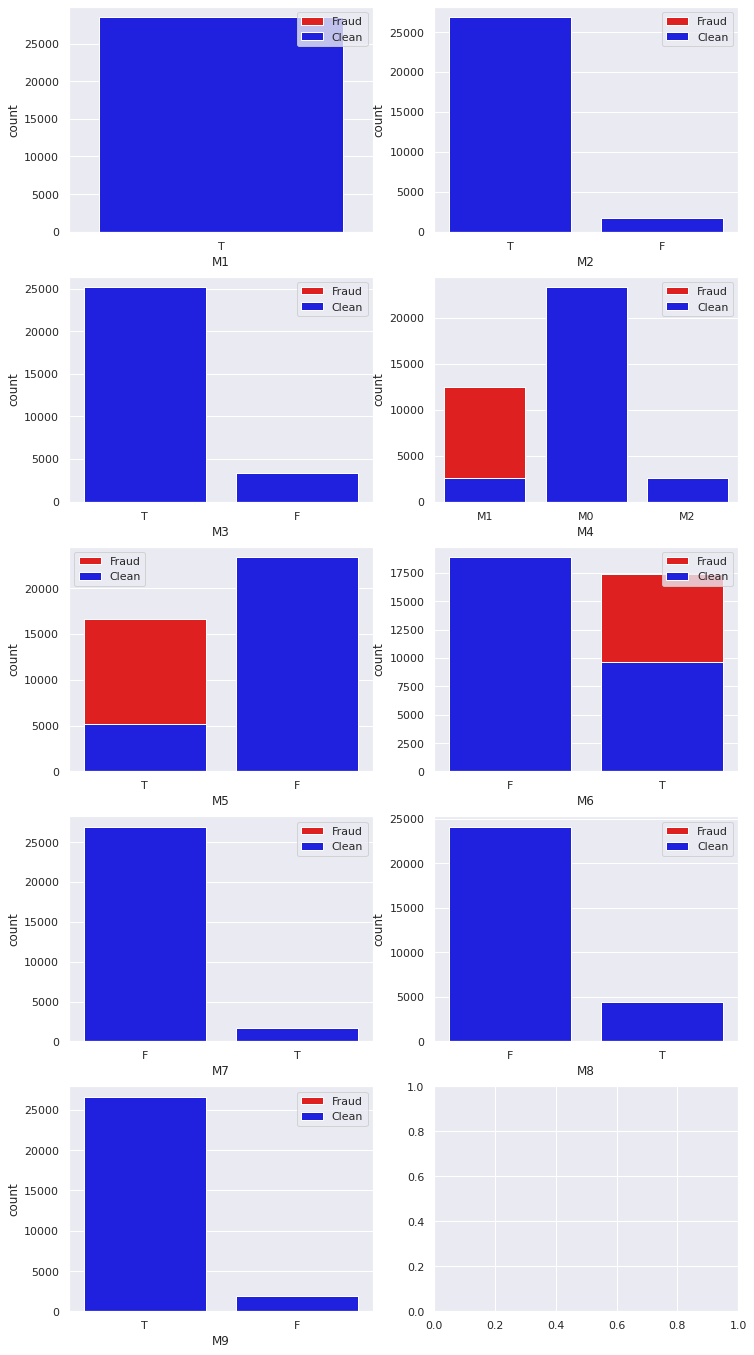

In [77]:
f, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 24))

feature = 1
for row in range(0, 5):
    for col in range(0, 2):
        if feature < 10:
            sns.countplot(M_p[f'M{feature}'], color='red', ax=ax[row,col], label='Fraud')
            sns.countplot(M_n[f'M{feature}'], color='blue', ax=ax[row,col], label='Clean')
            ax[row,col].legend()
            feature += 1


In [78]:
XCGM = XCG.join(M, how='inner')

In [79]:
XCGM.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,gmail.com,T,T,T,M0,F,T,F,F,T
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,hotmail.com,T,T,T,M2,F,F,F,F,T
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,hotmail.com,T,T,T,M2,F,F,F,F,T
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,hotmail.com,T,T,T,M2,F,F,F,F,T
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,outlook.com,T,T,T,M2,F,F,F,F,T


In [80]:
X_ = XCGM.copy()

In [81]:
X_[['TransactionAmt', 'card1', 'card2', 'dist1', 'dist2', 'addr1']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2', 'dist1', 'dist2', 'addr1']].add(1))
X_.loc[:, 'C1':'C14'] = numpy.log10(X_.loc[:, 'C1':'C14'].add(1))
X_[['card3', 'card5', 'card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'addr2']] =\
X_[['card3', 'card5', 'card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'addr2']].apply(LabelEncoder().fit_transform)
X_.loc[:, 'M1':'M9'] = X_.loc[:, 'M1':'M9'].apply(LabelEncoder().fit_transform)

In [82]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4.261715,2.766413,32,61,4,3,1,0.477121,0.477121,...,15,0,1,1,0,0,1,0,0,1
2987240,1.580902,4.127558,2.017033,48,21,0,3,1,0.000000,0.301030,...,18,0,1,1,2,0,0,0,0,1
2987243,1.580902,4.127558,2.017033,48,21,0,3,1,0.301030,0.301030,...,18,0,1,1,2,0,0,0,0,1
2987245,1.580902,4.127558,2.017033,48,21,0,3,1,0.477121,0.301030,...,18,0,1,1,2,0,0,0,0,1
2987288,2.194573,4.219558,2.737193,48,61,0,3,1,0.301030,0.301030,...,34,0,1,1,2,0,0,0,0,1


In [83]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [84]:
scores = output.get_booster().get_score(importance_type="gain")

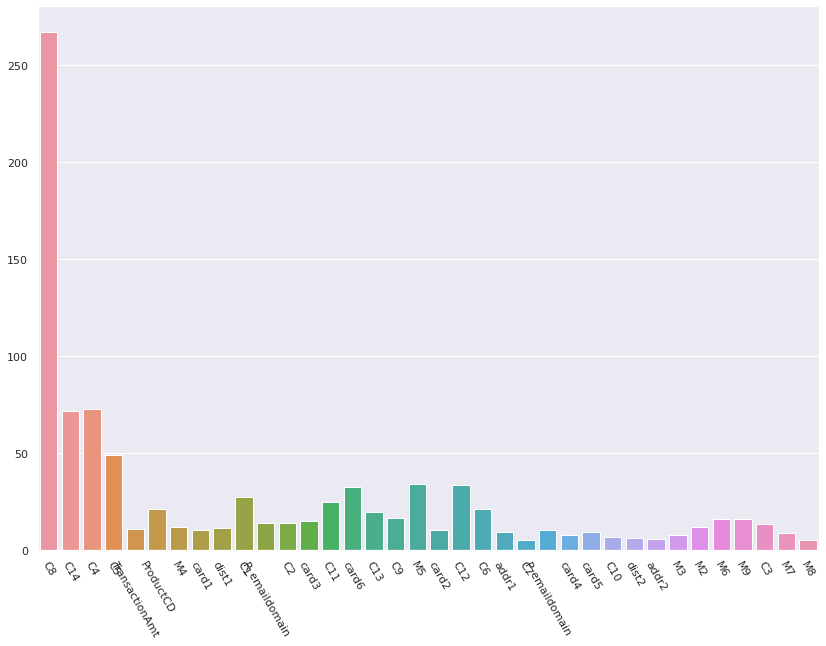

In [85]:
plt.figure(figsize=(14,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=300)
plt.show()

In [86]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_cgm = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8813, recall: 0.7905, f1: 0.8335, aucPR: 0.9204, aucROC: 0.9338
precision: 0.8707, recall: 0.7983, f1: 0.8329, aucPR: 0.9247, aucROC: 0.9353
precision: 0.8859, recall: 0.8036, f1: 0.8427, aucPR: 0.9341, aucROC: 0.9428
precision: 0.8811, recall: 0.8107, f1: 0.8445, aucPR: 0.9320, aucROC: 0.9438
precision: 0.8567, recall: 0.7957, f1: 0.8251, aucPR: 0.9209, aucROC: 0.9354
precision: 0.8679, recall: 0.8015, f1: 0.8334, aucPR: 0.9231, aucROC: 0.9337
precision: 0.8784, recall: 0.7870, f1: 0.8302, aucPR: 0.9257, aucROC: 0.9349
precision: 0.8862, recall: 0.7914, f1: 0.8361, aucPR: 0.9283, aucROC: 0.9390
precision: 0.8840, recall: 0.7928, f1: 0.8359, aucPR: 0.9271, aucROC: 0.9395
precision: 0.8657, recall: 0.7957, f1: 0.8293, aucPR: 0.9209, aucROC: 0.9317
Final - precision: 0.8758, recall: 0.7967, f1: 0.8344, aucPR: 0.9257, aucROC: 0.9370


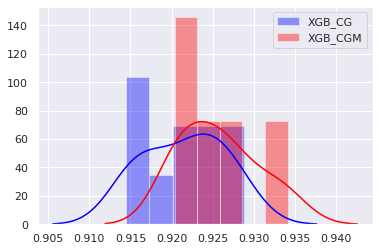

In [87]:
plt.figure()
sns.distplot(xgb_cg.aucs, color='blue', bins=5, label='XGB_CG')
sns.distplot(xgb_cgm.aucs, color='red', bins=5, label='XGB_CGM')
plt.legend()

In [88]:
ttest_rel(xgb_cgm.aucs, xgb_cg.aucs)

Ttest_relResult(statistic=4.045952308969174, pvalue=0.002902520940574961)

### D features

In [89]:
features = [f'D{i}' for i in range(1,16)]

In [90]:
D = X.loc[:, features]

In [91]:
D.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
TransactionID,,,,,,,,,,,,,,,
2987203,57.0,57.000000,52.000000,0.0,30.698406,54.462791,20.078215,81.548767,0.533472,80.0,130.490662,46.77314,10.20713,55.410862,374.0
2987240,0.0,141.396637,22.350887,0.0,30.698406,0.000000,20.078215,45.041664,0.041666,0.0,130.490662,0.00000,0.00000,0.000000,0.0
2987243,0.0,141.396637,22.350887,0.0,0.000000,0.000000,0.000000,45.041664,0.041666,0.0,130.490662,0.00000,0.00000,0.000000,0.0
2987245,0.0,141.396637,22.350887,0.0,0.000000,0.000000,0.000000,45.041664,0.041666,0.0,130.490662,0.00000,0.00000,0.000000,0.0
2987288,0.0,141.396637,22.350887,0.0,30.698406,0.000000,20.078215,81.548767,0.533472,0.0,130.490662,0.00000,0.00000,0.000000,0.0


In [92]:
D_p = D[y==1]
D_n = D[y==0]

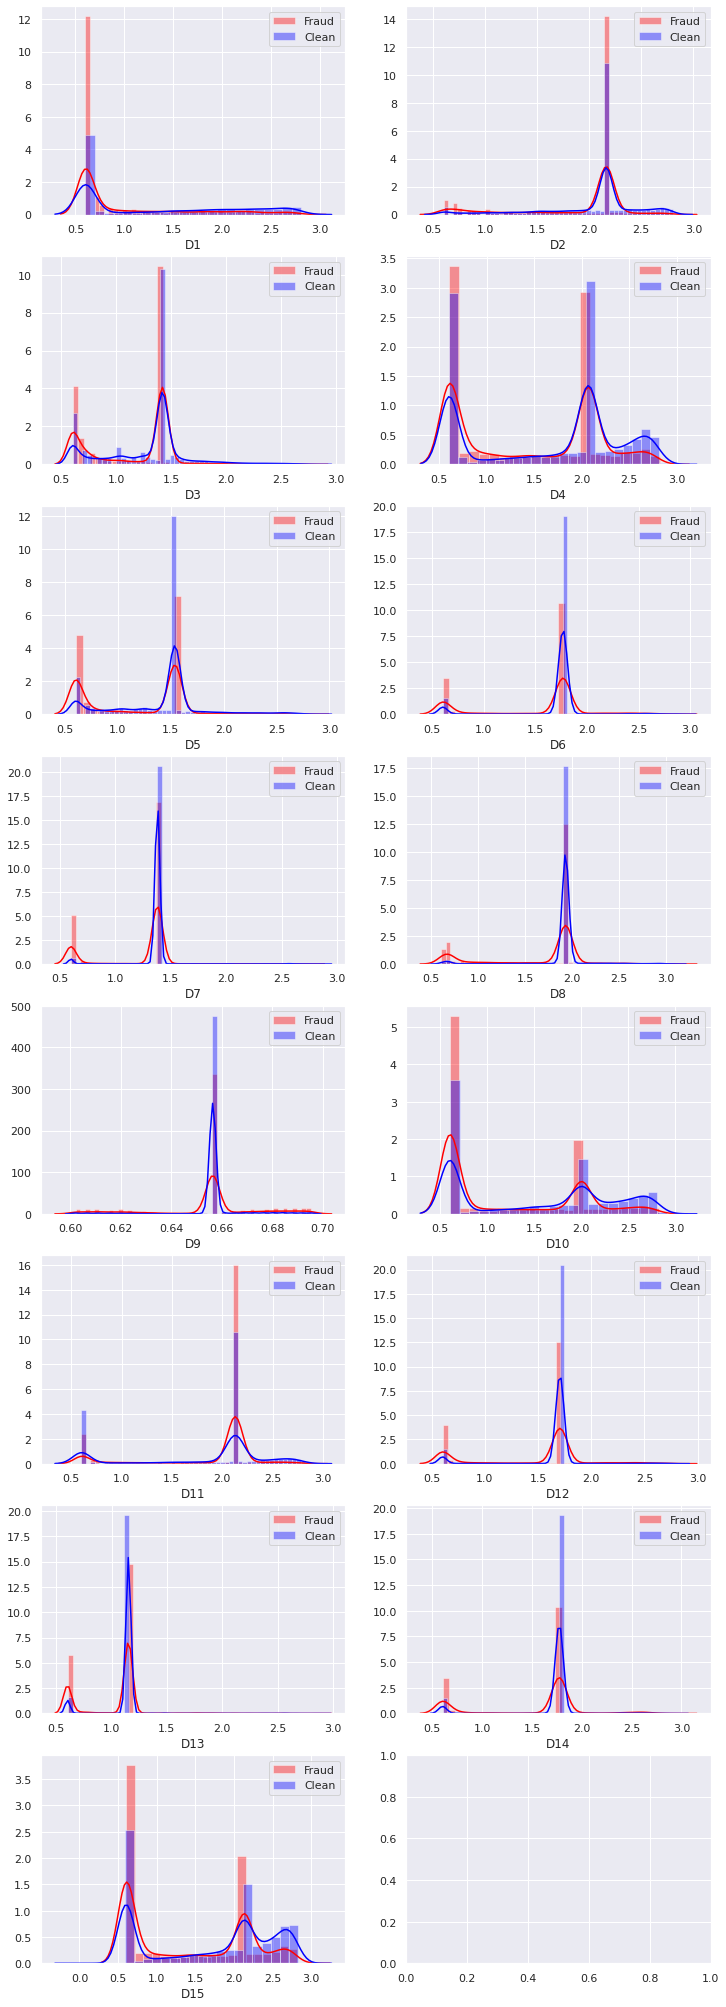

In [93]:
f, ax = plt.subplots(nrows=8, ncols=2, figsize=(12, 36))

feature = 1
for row in range(0, 8):
    for col in range(0, 2):
        if feature < 16:
            sns.distplot(numpy.log10(D_p[f'D{feature}'].add(4)), color='red', ax=ax[row,col], label='Fraud')
            sns.distplot(numpy.log10(D_n[f'D{feature}'].add(4)), color='blue', ax=ax[row,col], label='Clean')
            ax[row,col].legend()
            feature += 1

In [95]:
XCGMD = XCGM.join(D, how='inner')

In [96]:
XCGMD.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,54.462791,20.078215,81.548767,0.533472,80.0,130.490662,46.77314,10.20713,55.410862,374.0
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,0.000000,20.078215,45.041664,0.041666,0.0,130.490662,0.00000,0.00000,0.000000,0.0
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,0.000000,0.000000,45.041664,0.041666,0.0,130.490662,0.00000,0.00000,0.000000,0.0
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,0.000000,0.000000,45.041664,0.041666,0.0,130.490662,0.00000,0.00000,0.000000,0.0
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,0.000000,20.078215,81.548767,0.533472,0.0,130.490662,0.00000,0.00000,0.000000,0.0


In [97]:
X_ = XCGMD.copy()

In [98]:
X_[['TransactionAmt', 'card1', 'card2', 'dist1', 'dist2', 'addr1']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2', 'dist1', 'dist2', 'addr1']].add(1))
X_.loc[:, 'C1':'C14'] = numpy.log10(X_.loc[:, 'C1':'C14'].add(1))
X_[['card3', 'card5', 'card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'addr2']] =\
X_[['card3', 'card5', 'card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'addr2']].apply(LabelEncoder().fit_transform)
X_.loc[:, 'M1':'M9'] = X_.loc[:, 'M1':'M9'].apply(LabelEncoder().fit_transform)
X_.loc[:, 'D1':'D15'] = numpy.log10(X_.loc[:, 'D1':'D15'].add(4))

In [99]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4.261715,2.766413,32,61,4,3,1,0.477121,0.477121,...,1.76688,1.381624,1.932214,0.656431,1.924279,2.128692,1.705634,1.152506,1.773866,2.577492
2987240,1.580902,4.127558,2.017033,48,21,0,3,1,0.000000,0.301030,...,0.60206,1.381624,1.690565,0.606560,0.602060,2.128692,0.602060,0.602060,0.602060,0.602060
2987243,1.580902,4.127558,2.017033,48,21,0,3,1,0.301030,0.301030,...,0.60206,0.602060,1.690565,0.606560,0.602060,2.128692,0.602060,0.602060,0.602060,0.602060
2987245,1.580902,4.127558,2.017033,48,21,0,3,1,0.477121,0.301030,...,0.60206,0.602060,1.690565,0.606560,0.602060,2.128692,0.602060,0.602060,0.602060,0.602060
2987288,2.194573,4.219558,2.737193,48,61,0,3,1,0.301030,0.301030,...,0.60206,1.381624,1.932214,0.656431,0.602060,2.128692,0.602060,0.602060,0.602060,0.602060


In [100]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [101]:
scores = output.get_booster().get_score(importance_type="gain")

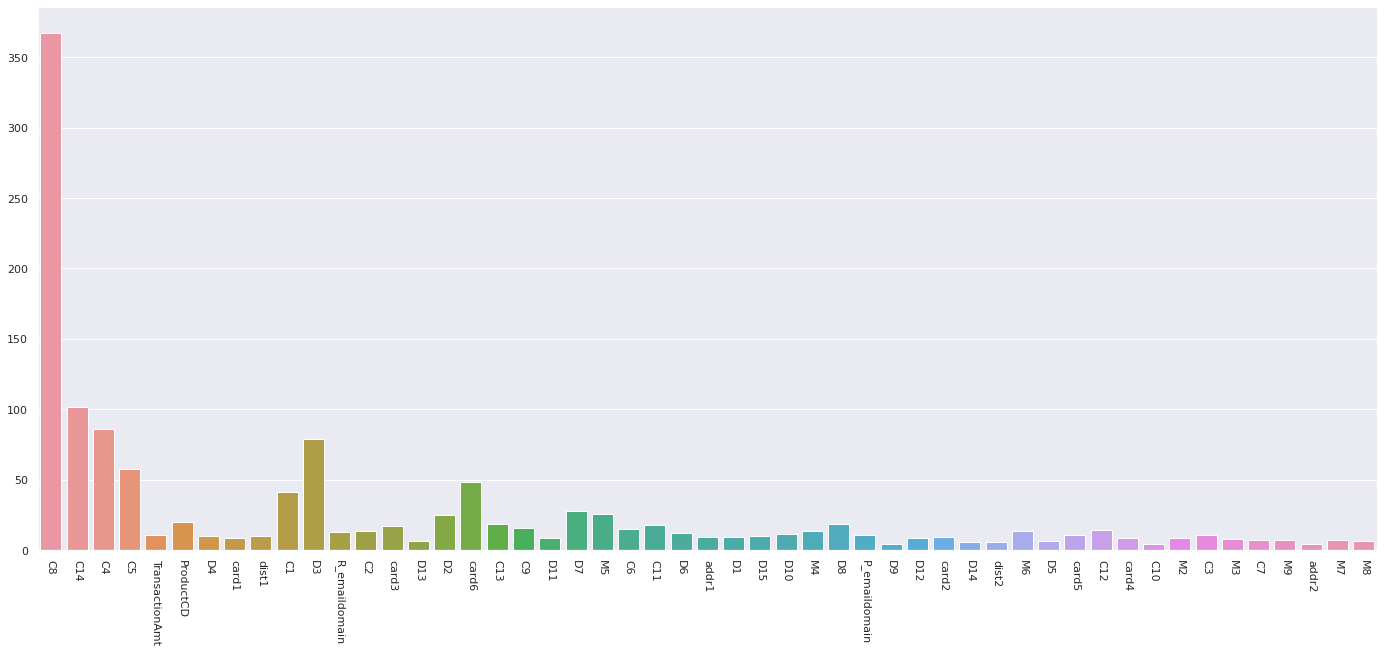

In [102]:
plt.figure(figsize=(24,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=270)
plt.show()

In [103]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_cgmd = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8757, recall: 0.8113, f1: 0.8423, aucPR: 0.9272, aucROC: 0.9369
precision: 0.8780, recall: 0.8079, f1: 0.8415, aucPR: 0.9302, aucROC: 0.9387
precision: 0.8973, recall: 0.8200, f1: 0.8569, aucPR: 0.9386, aucROC: 0.9455
precision: 0.8812, recall: 0.8219, f1: 0.8505, aucPR: 0.9355, aucROC: 0.9437
precision: 0.8568, recall: 0.8166, f1: 0.8362, aucPR: 0.9222, aucROC: 0.9347
precision: 0.8676, recall: 0.7962, f1: 0.8304, aucPR: 0.9245, aucROC: 0.9345
precision: 0.8883, recall: 0.8006, f1: 0.8422, aucPR: 0.9288, aucROC: 0.9358
precision: 0.8849, recall: 0.8224, f1: 0.8525, aucPR: 0.9360, aucROC: 0.9455
precision: 0.8912, recall: 0.8132, f1: 0.8504, aucPR: 0.9341, aucROC: 0.9444
precision: 0.8689, recall: 0.8020, f1: 0.8341, aucPR: 0.9238, aucROC: 0.9345
Final - precision: 0.8790, recall: 0.8112, f1: 0.8437, aucPR: 0.9301, aucROC: 0.9394


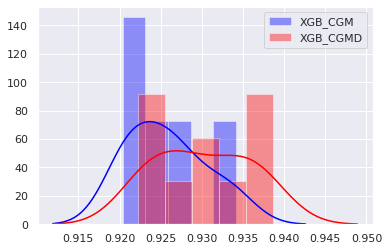

In [104]:
plt.figure()
sns.distplot(xgb_cgm.aucs, color='blue', bins=5, label='XGB_CGM')
sns.distplot(xgb_cgmd.aucs, color='red', bins=5, label='XGB_CGMD')
plt.legend()

In [105]:
ttest_rel(xgb_cgmd.aucs, xgb_cgm.aucs)

Ttest_relResult(statistic=5.938092674300859, pvalue=0.00021852726962640073)

## V features

In [106]:
features = [f'V{i}' for i in range(1,340)]

In [107]:
V = X[features]

In [108]:
V.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,1.0,1.055265,1.110204,0.858103,0.911221,1.050317,1.088032,1.034167,1.059559,0.39031,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987240,1.0,1.055265,1.110204,0.858103,0.911221,1.050317,1.088032,1.034167,1.059559,0.39031,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987243,1.0,1.055265,1.110204,0.858103,0.911221,1.050317,1.088032,1.034167,1.059559,0.39031,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987245,1.0,1.055265,1.110204,0.858103,0.911221,1.050317,1.088032,1.034167,1.059559,0.39031,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987288,1.0,1.055265,1.110204,0.858103,0.911221,1.050317,1.088032,1.034167,1.059559,0.39031,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199


In [109]:
XCGMDV = XCGMD.join(V, how='inner')

In [110]:
XCGMDV.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199


In [111]:
X_ = XCGMDV.copy()

In [112]:
X_[['TransactionAmt', 'card1', 'card2', 'dist1', 'dist2', 'addr1']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2', 'dist1', 'dist2', 'addr1']].add(1))
X_.loc[:, 'C1':'C14'] = numpy.log10(X_.loc[:, 'C1':'C14'].add(1))
X_[['card3', 'card5', 'card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'addr2']] =\
X_[['card3', 'card5', 'card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'addr2']].apply(LabelEncoder().fit_transform)
X_.loc[:, 'M1':'M9'] = X_.loc[:, 'M1':'M9'].apply(LabelEncoder().fit_transform)
X_.loc[:, 'D1':'D15'] = numpy.log10(X_.loc[:, 'D1':'D15'].add(4))
X_.loc[:, 'V1':'V339'] = numpy.log10(X_.loc[:, 'V1':'V339'].add(1))

In [113]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4.261715,2.766413,32,61,4,3,1,0.477121,0.477121,...,0.172362,2.547328,2.816658,2.68851,1.231761,1.756226,1.51216,1.641905,1.955803,1.820728
2987240,1.580902,4.127558,2.017033,48,21,0,3,1,0.000000,0.301030,...,0.172362,2.547328,2.816658,2.68851,1.231761,1.756226,1.51216,1.641905,1.955803,1.820728
2987243,1.580902,4.127558,2.017033,48,21,0,3,1,0.301030,0.301030,...,0.172362,2.547328,2.816658,2.68851,1.231761,1.756226,1.51216,1.641905,1.955803,1.820728
2987245,1.580902,4.127558,2.017033,48,21,0,3,1,0.477121,0.301030,...,0.172362,2.547328,2.816658,2.68851,1.231761,1.756226,1.51216,1.641905,1.955803,1.820728
2987288,2.194573,4.219558,2.737193,48,61,0,3,1,0.301030,0.301030,...,0.172362,2.547328,2.816658,2.68851,1.231761,1.756226,1.51216,1.641905,1.955803,1.820728


In [114]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [115]:
scores = output.get_booster().get_score(importance_type="gain")

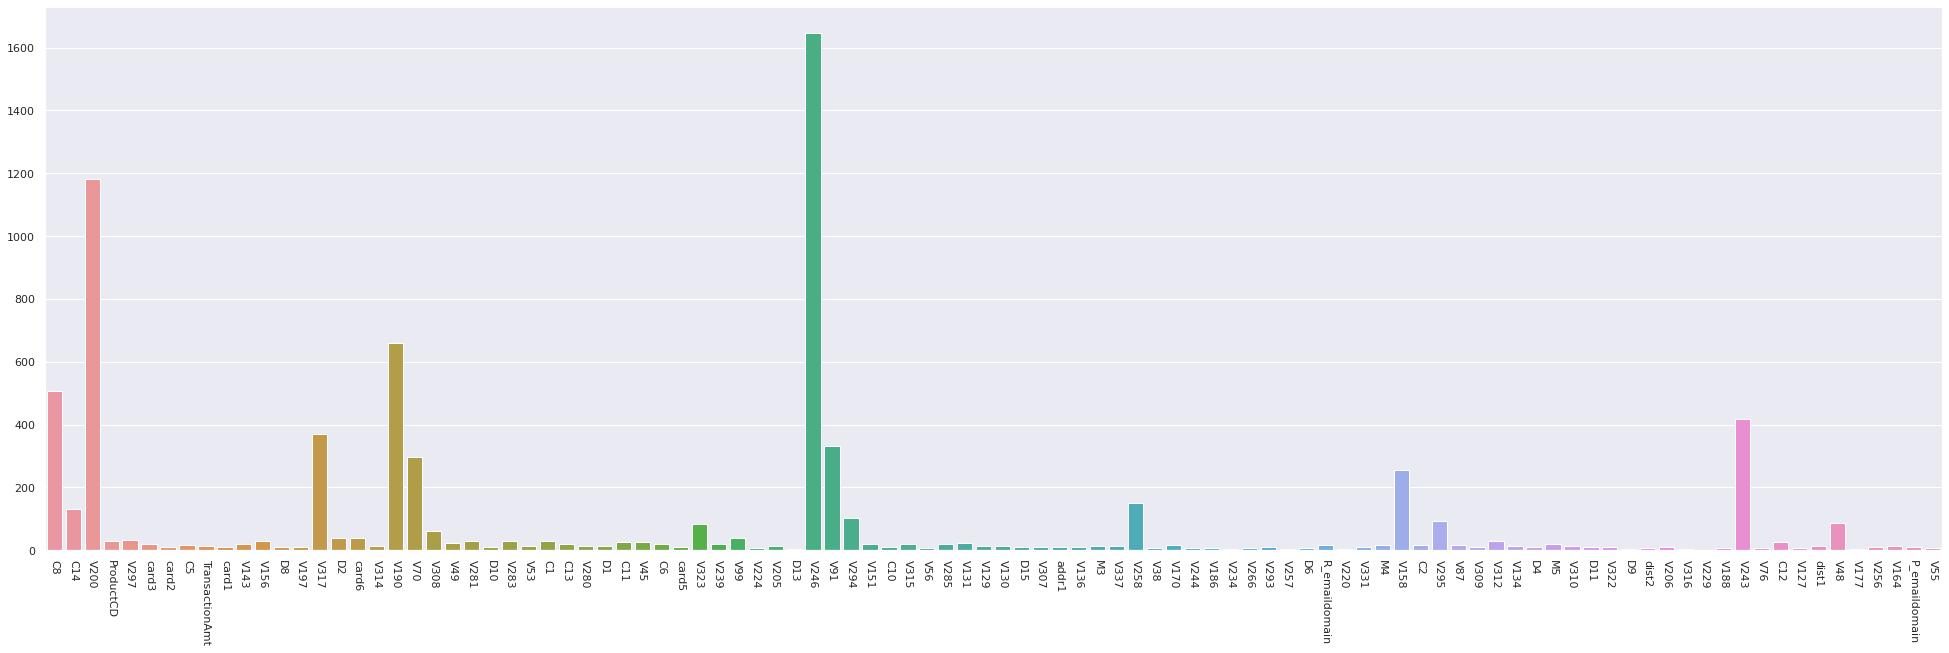

In [116]:
plt.figure(figsize=(34,10))
sns.barplot(x=list(scores.keys())[0:100], y=list(scores.values())[0:100])
plt.xticks(rotation=270)
plt.show()

In [117]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_cgmdv = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8824, recall: 0.8021, f1: 0.8403, aucPR: 0.9296, aucROC: 0.9371
precision: 0.8806, recall: 0.7992, f1: 0.8379, aucPR: 0.9277, aucROC: 0.9357
precision: 0.8971, recall: 0.8060, f1: 0.8491, aucPR: 0.9386, aucROC: 0.9441
precision: 0.8939, recall: 0.8199, f1: 0.8553, aucPR: 0.9390, aucROC: 0.9471
precision: 0.8639, recall: 0.8204, f1: 0.8416, aucPR: 0.9261, aucROC: 0.9379
precision: 0.8798, recall: 0.7938, f1: 0.8346, aucPR: 0.9261, aucROC: 0.9347
precision: 0.8852, recall: 0.7914, f1: 0.8357, aucPR: 0.9284, aucROC: 0.9339
precision: 0.8803, recall: 0.7977, f1: 0.8370, aucPR: 0.9309, aucROC: 0.9395
precision: 0.8885, recall: 0.8059, f1: 0.8452, aucPR: 0.9338, aucROC: 0.9420
precision: 0.8675, recall: 0.8020, f1: 0.8335, aucPR: 0.9270, aucROC: 0.9353
Final - precision: 0.8819, recall: 0.8039, f1: 0.8410, aucPR: 0.9307, aucROC: 0.9387


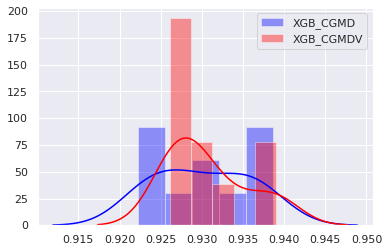

In [118]:
plt.figure()
sns.distplot(xgb_cgmd.aucs, color='blue', bins=5, label='XGB_CGMD')
sns.distplot(xgb_cgmdv.aucs, color='red', bins=5, label='XGB_CGMDV')
plt.legend()

In [119]:
ttest_rel(xgb_cgmd.aucs, xgb_cgmdv.aucs)

Ttest_relResult(statistic=-0.6834767504878748, pvalue=0.5115161452104733)

## Identity features

In [120]:
types = {(f'id_0{i}' if i<10 else f'id_{i}'): 'float32' for i in range(1, 12)}
types.update({f'id_{i}': 'category' for i in range(12, 39)})
types.update({'DeviceType': 'category', 'DeviceInfo': 'category'})

In [121]:
types

{'id_01': 'float32',
 'id_02': 'float32',
 'id_03': 'float32',
 'id_04': 'float32',
 'id_05': 'float32',
 'id_06': 'float32',
 'id_07': 'float32',
 'id_08': 'float32',
 'id_09': 'float32',
 'id_10': 'float32',
 'id_11': 'float32',
 'id_12': 'category',
 'id_13': 'category',
 'id_14': 'category',
 'id_15': 'category',
 'id_16': 'category',
 'id_17': 'category',
 'id_18': 'category',
 'id_19': 'category',
 'id_20': 'category',
 'id_21': 'category',
 'id_22': 'category',
 'id_23': 'category',
 'id_24': 'category',
 'id_25': 'category',
 'id_26': 'category',
 'id_27': 'category',
 'id_28': 'category',
 'id_29': 'category',
 'id_30': 'category',
 'id_31': 'category',
 'id_32': 'category',
 'id_33': 'category',
 'id_34': 'category',
 'id_35': 'category',
 'id_36': 'category',
 'id_37': 'category',
 'id_38': 'category',
 'DeviceType': 'category',
 'DeviceInfo': 'category'}

In [122]:
data = df.read_csv('./data/train_identity.csv', header=0, dtype=types).set_index('TransactionID')

In [123]:
data.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [124]:
data.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 40 entries, id_01 to DeviceInfo
dtypes: category(29), float32(11)

In [125]:
data.isnull().sum().compute()

id_01              0
id_02           3361
id_03          77909
id_04          77909
id_05           7368
id_06           7368
id_07         139078
id_08         139078
id_09          69307
id_10          69307
id_11           3255
id_12              0
id_13          16913
id_14          64189
id_15           3248
id_16          14893
id_17           4864
id_18          99120
id_19           4915
id_20           4972
id_21         139074
id_22         139064
id_23         139064
id_24         139486
id_25         139101
id_26         139070
id_27         139064
id_28           3255
id_29           3255
id_30          66668
id_31           3951
id_32          66647
id_33          70944
id_34          66428
id_35           3248
id_36           3248
id_37           3248
id_38           3248
DeviceType      3423
DeviceInfo     25567
dtype: int64